本文先介绍了VGG的基本原理，然后详细介绍了如何使用tensorflow2.x实现VGG网络。
其中VGG原理参考了https://zhuanlan.zhihu.com/p/41423739

# 1、VGG原理

VGG是Oxford的Visual Geometry Group的组提出的（大家应该能看出VGG名字的由来了）。该网络是在ILSVRC 2014上的相关工作，主要工作是证明了增加网络的深度能够在一定程度上影响网络最终的性能。VGG有两种结构，分别是VGG16和VGG19，两者并没有本质上的区别，只是网络深度不一样。

VGG16相比AlexNet的一个改进是采用连续的几个3x3的卷积核代替AlexNet中的较大卷积核（11x11，7x7，5x5）。对于给定的感受野（与输出有关的输入图片的局部大小），采用堆积的小卷积核是优于采用大的卷积核，因为多层非线性层可以增加网络深度来保证学习更复杂的模式，而且代价还比较小（参数更少）。

简单来说，在VGG中，使用了3个3x3卷积核来代替7x7卷积核，使用了2个3x3卷积核来代替5*5卷积核，这样做的主要目的是在保证具有相同感知野的条件下，提升了网络的深度，在一定程度上提升了神经网络的效果。

比如，3个步长为1的3x3卷积核的一层层叠加作用可看成一个大小为7的感受野（其实就表示3个3x3连续卷积相当于一个7x7卷积），其参数总量为 3x(9xC^2) ，如果直接使用7x7卷积核，其参数总量为 49xC^2 ，这里 C 指的是输入和输出的通道数。很明显，27xC^2小于49xC^2，即减少了参数；而且3x3卷积核有利于更好地保持图像性质。

这里解释一下为什么使用2个3x3卷积核可以来代替5*5卷积核：

5x5卷积看做一个小的全连接网络在5x5区域滑动，我们可以先用一个3x3的卷积滤波器卷积，然后再用一个全连接层连接这个3x3卷积输出，这个全连接层我们也可以看做一个3x3卷积层。这样我们就可以用两个3x3卷积级联（叠加）起来代替一个 5x5卷积。

具体如下图所示：
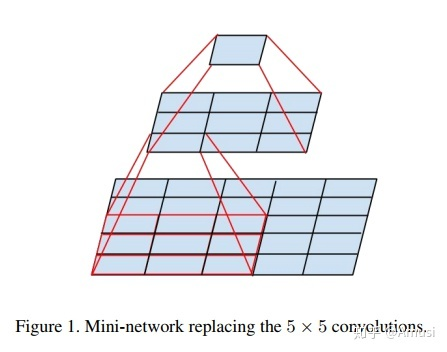

至于为什么使用3个3x3卷积核可以来代替7*7卷积核，推导过程与上述类似，大家可以自行绘图理解。

VGG网络结构
下面是VGG网络的结构（VGG16和VGG19都在）：
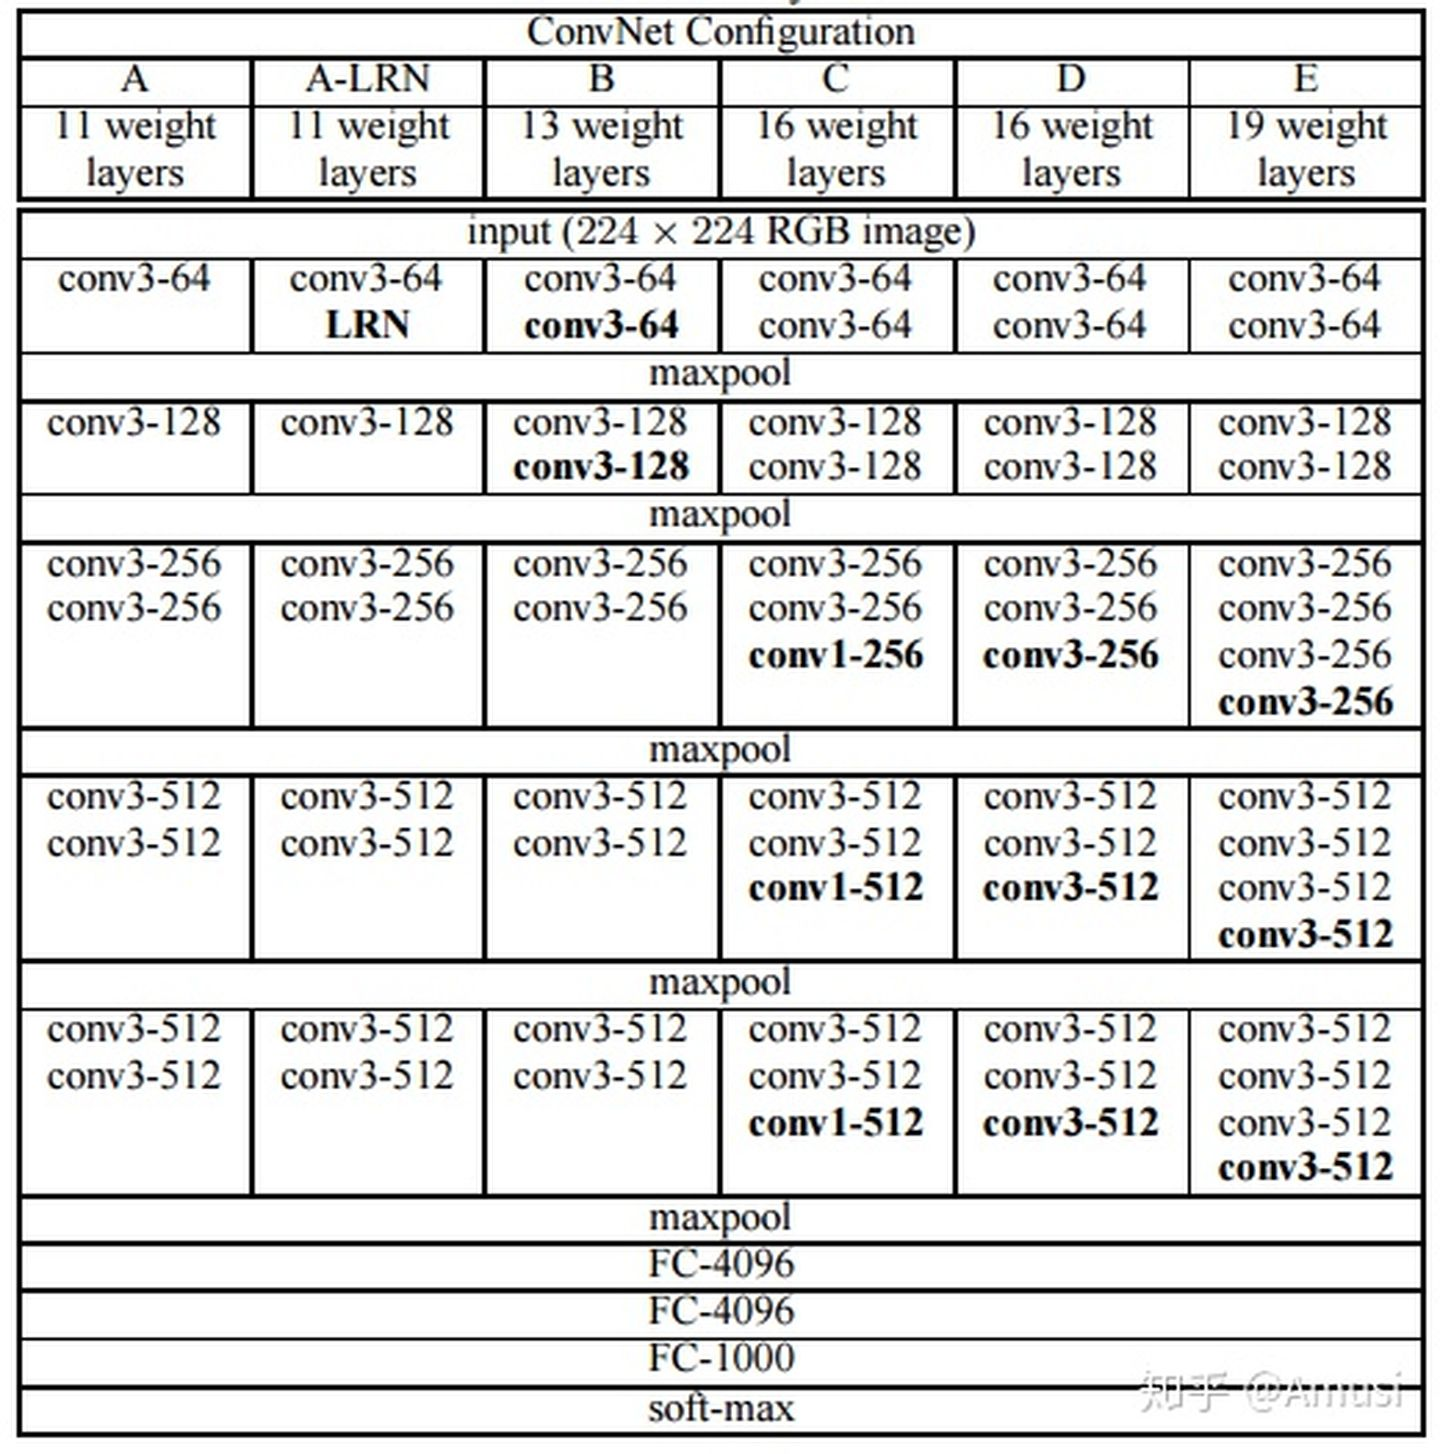

- VGG16包含了16个隐藏层（13个卷积层和3个全连接层），如上图中的D列所示

- VGG19包含了19个隐藏层（16个卷积层和3个全连接层），如上图中的E列所示



VGG网络的结构非常一致，从头到尾全部使用的是3x3的卷积和2x2的max pooling。



如果你想看到更加形象化的VGG网络，可以使用经典卷积神经网络（CNN）结构可视化工具来查看高清无码的VGG网络。



**VGG优点**

VGGNet的结构非常简洁，整个网络都使用了同样大小的卷积核尺寸（3x3）和最大池化尺寸（2x2）。
几个小滤波器（3x3）卷积层的组合比一个大滤波器（5x5或7x7）卷积层好：
验证了通过不断加深网络结构可以提升性能。


**VGG缺点**

VGG耗费更多计算资源，并且使用了更多的参数（这里不是3x3卷积的锅），导致更多的内存占用（140M）。其中绝大多数的参数都是来自于第一个全连接层。VGG可是有3个全连接层啊！
PS：有的文章称：发现这些全连接层即使被去除，对于性能也没有什么影响，这样就显著降低了参数数量。



注：很多pretrained的方法就是使用VGG的model（主要是16和19），VGG相对其他的方法，参数空间很大，最终的model有500多m，AlexNet只有200m，GoogLeNet更少，所以train一个vgg模型通常要花费更长的时间，所幸有公开的pretrained model让我们很方便的使用。



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers,metrics,optimizers
import pandas as pd
import numpy as np

# 2、使用tensorflow实现VGG网络
## 2.1、构建VGG网络
我们先看看我们要实现的VGG16网络：
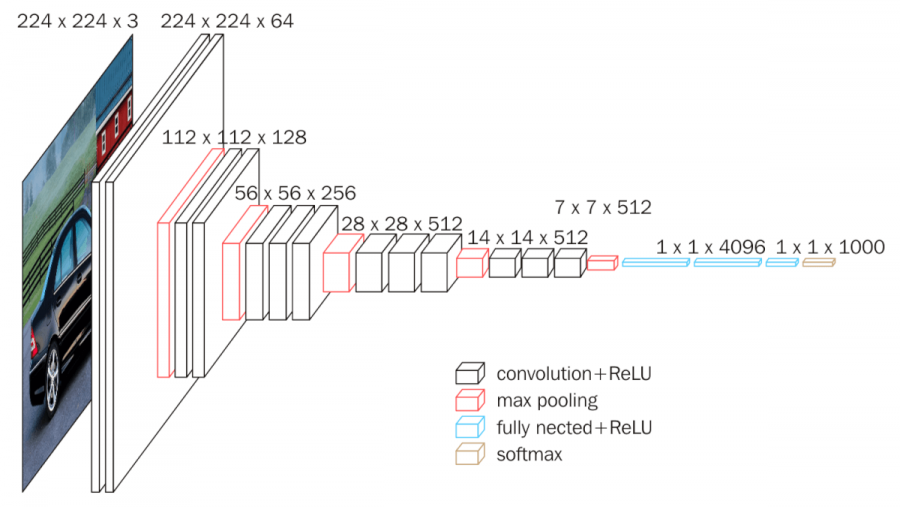

用tensorflow定义网络结构：

In [2]:
def build_vgg16_model():
    weight_decay = 0.000
    num_classes = 10
    input_shape = (32, 32, 3)

    model = keras.models.Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                 input_shape=input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    # model.add(layers.Activation('softmax'))
    
    return model


我们看一下模型：

In [3]:
model = build_vgg16_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

我们对参数数量做一个简单说明：

使用卷积层，将参数数量从全连接网络的输入层大小m * 输出层大小n， 缩小为滤波器的数量大小k * k，一般而言，k远小于m和n。
对于多通道多卷积核而言，参数数量为$k*k*channels*filters$。其中channels为通道的数量，一般等于上一层的滤波器数量（对于第一层就是输入层的通道数量），filters为卷积层里面滤波器的数量。

**从这里也可以看出，每层的滤波器和上一层的滤波器之间是全连接关系**

概括的说，对于$m*n$的输入图片，假如是RGB三通道，而卷积层有filters个滤波器，每个滤波器的大小为 $k*k$，则参数数量为为$k*k*3*filters$。也就是说每个滤波器对应每个输入通道都有一个专门的参数矩阵。

总结
* 每个卷积层的大小是滤波器的大小$（k*k) * 滤波器的数量 * 输入的通道数量（即上一层输出的通道数量）$。
* 每个滤波器内的多个通道得到的最终结果，会按位相加得到最终一个输出矩阵，所以每一个卷积层输出filter个通道，这也是下一层的输入通道数量。

我们详细说明上述网络中的参数数量：
* 对于第一层conv2d (Conv2D)，参数数量为$3*3*滤波器数量64*输入通道数量3+偏置项64=1792$
* 对于第二次conv2d_1 (Conv2D)，参数数量为$3*3*滤波器数量64*输入通道数量64+偏置项64=36928$
* 对于第六层conv2d_5 (Conv2D)：参数数量为$3*3*滤波器数量256*输入通道数量256+偏置项256=590080$
* 对于最后一个卷积层conv2d_12 (Conv2D)：参数数量为$3*3*滤波器数量512*输入通道数量512+偏置项512=2359808$

## 2.2、加载CIFAR10数据集

CIFAR10数据集由加拿大CanadianInstituteForAdvancedResearch发布，它包含了飞机、汽车、鸟、猫共十大类物体的彩色图片，每个种类收集了6000张32×32大小图片，共60000张图片。其中50000张作为训练数据集，1万张作为测试数据集。

在TensorFlow中，同样地，不需要手动下载、解析和加载CIFAR10数据集，通过datasets.cifar10.load_data（）函数就可以直接加载切割好的训练集和测试集。

In [4]:
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


## 2.3、数据预处理

删除y的一个纬度，从[b,1]变成[b,]，否则做onehot后纬度会变成[b,1,10]，而不是[b,10]

In [5]:
# y预处理
def y_preprocess(y_train, y_test):
    # 删除y的一个纬度，从[b,1]变成[b,]，否则做onehot后纬度会变成[b,1,10]，而不是[b,10]
    y_train = tf.squeeze(y_train, axis=1)
    y_test = tf.squeeze(y_test, axis=1)
    # onehot
    y_train = tf.one_hot(y_train, depth=10)
    y_test = tf.one_hot(y_test, depth=10)
    return y_train, y_test

对X做了标准化。

In [6]:
# x预处理
def x_preprocess(x_train, x_test):
    #数据标准化
    x_train = x_train/255.0
    x_test = x_test/255.0
    
    x_mean = x_train.mean()
    x_std = x_train.std()
    x_train = (x_train-x_mean)/x_std
    x_test = (x_test-x_mean)/x_std
    print(x_train.max(), x_train.min(), x_train.mean(), x_train.std())
    print(x_test.max(), x_test.min(), x_test.mean(), x_test.std())
    # 改成float32加快训练速度，避免使用float64。其实默认就是float32。
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    return x_train, x_test  

In [7]:
y_train, y_test = y_preprocess(y_train, y_test)
x_train, x_test = x_preprocess(x_train, x_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


2.0934103819959744 -1.8816433721538914 9.83429634023499e-15 1.0000000000000042
2.0934103819959744 -1.8816433721538914 0.0128073056421839 0.9986109795368511
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


## 2.4、训练模型

此处使用loss=mse收敛较快，loss=categorical_crossentropy收敛很慢。

In [ ]:
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[keras.metrics.CategoricalAccuracy()])
# model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
#               metrics=[keras.metrics.CategoricalAccuracy()])
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20
1563/1563 [==============================] - 344s 219ms/step - loss: 0.4755 - categorical_accuracy: 0.1288 - val_loss: 0.0916 - val_categorical_accuracy: 0.1174
Epoch 2/20
1563/1563 [==============================] - 344s 220ms/step - loss: 0.0928 - categorical_accuracy: 0.1983 - val_loss: 0.0906 - val_categorical_accuracy: 0.1636
Epoch 3/20
1563/1563 [==============================] - 344s 220ms/step - loss: 0.0863 - categorical_accuracy: 0.2540 - val_loss: 0.0902 - val_categorical_accuracy: 0.2334
Epoch 4/20
1563/1563 [==============================] - 346s 221ms/step - loss: 0.0840 - categorical_accuracy: 0.3132 - val_loss: 0.0765 - val_categorical_accuracy: 0.3912
Epoch 5/20
1563/1563 [==============================] - 343s 219ms/step - loss: 0.0721 - categorical_accuracy: 0.4716 - val_loss: 0.0624 - val_categorical_accuracy: 0.5493
Epoch 6/20
1563/1563 [==============================] - 341s 218ms/step - loss: 0.0594 - categorical_accuracy: 0.5895 - val_loss: 0.0519 - v

也可以使用dataset的方式进行训练：

In [ ]:
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#必须batch()，否则少了一个维度，shapeError。
ds_train = ds_train.shuffle(50000).batch(32).repeat(1)
ds_test = ds_test.shuffle(50000).batch(32).repeat(1)

model.fit(ds_train, validation_data=ds_test, epochs=20)

## 2.5、完整代码

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers,metrics,optimizers
import pandas as pd
import numpy as np

def build_vgg16_model():
    weight_decay = 0.000
    num_classes = 10
    input_shape = (32, 32, 3)

    model = keras.models.Sequential()

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same',
                 input_shape=input_shape, kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))


    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes))
    # model.add(layers.Activation('softmax'))
    
    return model

model = build_vgg16_model()

(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# y预处理
def y_preprocess(y_train, y_test):
    # 删除y的一个纬度，从[b,1]变成[b,]，否则做onehot后纬度会变成[b,1,10]，而不是[b,10]
    y_train = tf.squeeze(y_train, axis=1)
    y_test = tf.squeeze(y_test, axis=1)
    # onehot
    y_train = tf.one_hot(y_train, depth=10)
    y_test = tf.one_hot(y_test, depth=10)
    return y_train, y_test

# x预处理
def x_preprocess(x_train, x_test):
    #数据标准化
    x_train = x_train/255.0
    x_test = x_test/255.0
    
    x_mean = x_train.mean()
    x_std = x_train.std()
    x_train = (x_train-x_mean)/x_std
    x_test = (x_test-x_mean)/x_std
    print(x_train.max(), x_train.min(), x_train.mean(), x_train.std())
    print(x_test.max(), x_test.min(), x_test.mean(), x_test.std())
    # 改成float32加快训练速度，避免使用float64
    x_train = x_train.astype(np.float32)
    x_test = x_test.astype(np.float32)
    return x_train, x_test  


y_train, y_test = y_preprocess(y_train, y_test)
x_train, x_test = x_preprocess(x_train, x_test)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[keras.metrics.CategoricalAccuracy()])

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)
# 最后一行代码也可以使用dataset的方式代替
# ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
# #必须batch()，否则少了以为，shapeError。
# ds_train = ds_train.shuffle(50000).batch(32).repeat(1)
# ds_test = ds_test.shuffle(50000).batch(32).repeat(1)

# model.fit(ds_train, validation_data=ds_test, epochs=20)